In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

/Users/mads/miniconda3/envs/pml-env2/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# 1. Train the model on the MNIST dataset, using a 2-dimensional latent space. Plot this latent space in the same way as you did for PPCA, using colors to represent the different digits. Does it separate the classes better than PPCA?

In [2]:
cuda2 = False # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
batch_size2 = 128
log_interval2 = 10
epochs2 = 4 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 188.5660
====> Test set loss: 166.2195
====> Epoch: 2 Average loss: 162.5050
====> Test set loss: 159.4954
====> Epoch: 3 Average loss: 157.1092
====> Test set loss: 155.2704
====> Epoch: 4 Average loss: 153.5683
====> Test set loss: 152.4658


### Find expected value in latent space for each number

In [3]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

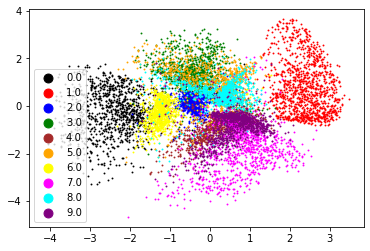

In [4]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

# 2. Now let's visualize the output in a different way...

In [5]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

In [6]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

/Users/mads/miniconda3/envs/pml-env2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


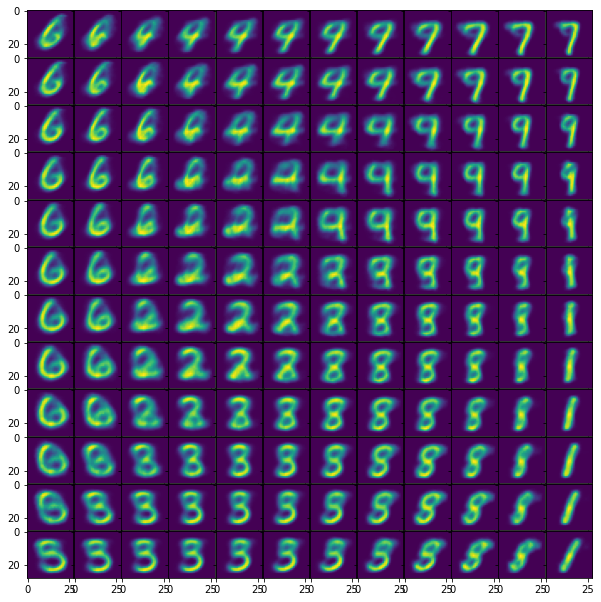

In [7]:
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

# torch.distributions

In [8]:
cuda2 = False # torch.cuda.is_available() check if a gpu is available
batch_size2 = 128
log_interval2 = 10
epochs2 = 2 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return torch.distributions.normal.Normal(loc = self.fc21(h2), scale = torch.exp(0.5*self.fc22(h2)))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x): # model(data) = model.forward(data)
        gauss = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 184.5907
====> Test set loss: 161.4545
====> Epoch: 2 Average loss: 158.1956
====> Test set loss: 154.9689


### Find expected value in latent space for each number

In [9]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat).mean
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

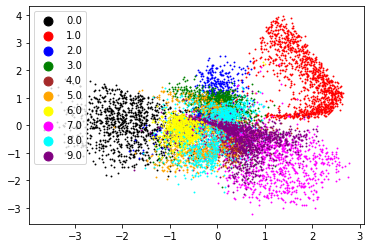

In [10]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

# IWAE

In [15]:
cuda2 = False # torch.cuda.is_available() check if a gpu is available
batch_size2 = 128
log_interval2 = 10
epochs2 = 10 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

In [16]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x): # model(data) = model.forward(data)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def loss_function(recon_x, x, mu, logvar): # compute_marginal_log_likelihood(self, x, k=None):
    k = 10
    x = torch.round(x)
    Q_z_given_x = torch.distributions.normal.Normal(loc = mu, scale = torch.exp(logvar))

    z = Q_z_given_x.rsample(torch.tensor([k])) # torch.Size([10, 128, 2])
    x_tilde = model.decode(z)

    # upsample mu, std, x_s
    mu_z_s = mu.unsqueeze(0).repeat(k, 1, 1)
    std_z_s = (0.5 * logvar).exp().unsqueeze(0).repeat(k, 1, 1)
    x_s = x.view(-1,784).unsqueeze(0).repeat(k, 1, 1)

    log_p_x_g_z = torch.distributions.Bernoulli(x_tilde).log_prob(x_s).sum(axis=-1)
    log_prior_z = torch.distributions.Normal(0, 1).log_prob(z).sum(axis=-1)
    log_q_z_g_x = torch.distributions.Normal(mu_z_s, std_z_s).log_prob(z).sum(axis=-1)
    log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x

    log_marginal_likelihood = (torch.logsumexp(log_w, 1) -  np.log(k)).mean()
    return -log_marginal_likelihood

In [18]:
def train(epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 0.4009
====> Test set loss: 0.3178
====> Epoch: 2 Average loss: 0.3105
====> Test set loss: 0.2753


In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

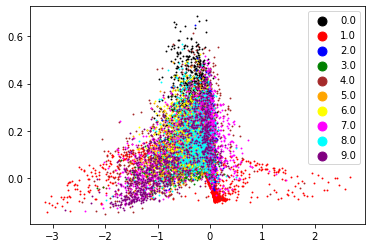

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()